## Imports

In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

In [2]:
import torch
import torch.nn.functional as F
from datasets import load_dataset,concatenate_datasets
import transformers
from sklearn.metrics import confusion_matrix


from transformers import AutoTokenizer, DataCollatorWithPadding,BertForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
from tqdm import tqdm
import logging
import warnings
import re
import pandas as pd
from newspaper import Article
from nltk import sent_tokenize
import seaborn as sns

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

DATA_PATH = PATH + '/data/Inference/'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("horychtom/czech_media_bias_classifier")

BATCH_SIZE = 32

## Function definitions

In [3]:
def classify_sentence(sent:str):
    """Clasification of a single sentence

    Args:
        sent (str): sentence to be classified
    Returns:
        int: label either 0 or 1 (unbiased/biased) 
    """
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).argmax(dim=1)
    
    return classification[0].item()

In [5]:
def classify_article(url:str):
    """classifies news article

    Args:
        url (str): link to article to be classified

    Returns:
        (numpy array of labels with sentences,probabilities): zipped annotations and sentences
    """
    article = Article(url)
    article.download()
    article.parse()
    sentences = sent_tokenize(article.text)
    annotations = np.array(list(zip(sentences,list(map(classify_sentence,sentences)))))
    probabilities = np.array(list(zip(sentences,list(map(classify_sentence_bias_prob,sentences)))))
    return annotations,probabilities

In [6]:
def strip_domains(data):
    """removes prefixes from domains
       example: subdomain:= novinky.cz <- sport.novinky.cz 
                section:=sport <- sport.novinky.cz

    Args:
        data (pandas dataframe) with 'subdomain' column
    """
    get_domain = lambda x : '.'.join(x.split('.')[-2:])
    get_section = lambda x : x.split('.')[0] if '.' in x else x
    data['subdomain'] = data['subdomain'].apply(get_domain)
    data['section'] = data['section'].apply(get_section)
    
    return data

In [7]:
def date_format(data):
    """strips irrelevant details of dates
    """
    data['published'] = data['published'].apply(lambda x: x[:7])
    data = data.assign(Year = data['published'].apply(lambda x: int(x[:4])))
    
    return data

In [8]:
def assign_bias_ratio(data,split:str):
    """computes bias frequency for each row (article) in the dataset

    Args:
        data (pandas dataframe): articles
        split (str): abstract, text or headline
    """
    size = len(data)
    values = np.zeros(size)
    
    for i in tqdm(range(size)):
        text = data.iloc[i][split]
        sentences = sent_tokenize(text)
        labels = np.array(list(map(classify_sentence,sentences)))
        values[i] = 100*np.sum(labels)/len(labels)
    
    data.insert(0,split+'_bias',values)
    
    return data

In [10]:
def assign_quote_ratio(data):
    """for each row (article) computes frequency of quoting
    """
    size = len(data)
    qvalues = np.zeros(size)

    r = re.compile('„|"')
    
    for i in tqdm(range(size)):
        text = data.iloc[i]['text']
        sentences = sent_tokenize(text)
        
        # quoting
        result = np.array(list(map(r.search, sentences)))
        qindices = np.where(np.array(result) != None)[0]

        qvalues[i] = 100*len(qindices)/len(sentences)
    
    data.insert(0,'quoting_ratio',qvalues)
    
    return data

In [11]:
def assign_bias_headline(data):
    """computes binary label for headlines
    """
    size = len(data)
    values = np.zeros(size)
    
    for i in tqdm(range(size)):
        text = data.iloc[i]['headline']
        values[i] = classify_sentence(text)
        
    data.insert(0,'headline_bias',values)
    
    return data

## Load and clean data from RCI repo

In [81]:
test = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-test.jsonl',lines=True)
dev = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-dev.jsonl',lines=True)
train = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-train.jsonl',lines=True)

#train is too big, train is only used to get more of CTK
data = pd.concat([test,dev])

#throaway blogs
data = data[~data['subdomain'].str.contains('blog')]

In [ ]:
data = data[data['published']!='']
data = date_format(data)
data = strip_domains(data)
data.drop(['filename', 'dataset','md5','offset'], axis=1, inplace=True)

In [57]:
train = train[train['published']!='']
train = date_format(train)
train = strip_domains(train)
train.drop(['filename', 'dataset','md5','offset'], axis=1, inplace=True)

In [76]:
ctk1 = train[train['subdomain']=='ceskenoviny.cz']
ctk2 = data[data['subdomain'] == 'ceskenoviny.cz']

In [83]:
ctk = pd.concat([ctk1,ctk2])
denik = data[data.subdomain == 'denik.cz']
idnes = data[data.subdomain == 'idnes.cz']
lidovky = data[data.subdomain == 'lidovky.cz']
novinky = data[data.subdomain == 'novinky.cz']

## lidovky

In [100]:
lidovky = assign_bias_ratio(lidovky,'abstract')

100%|██████████| 11892/11892 [08:04<00:00, 24.53it/s]


In [101]:
lidovky = assign_bias_headline(lidovky)

100%|██████████| 11892/11892 [02:52<00:00, 68.92it/s]


In [104]:
lidovky = assign_bias_ratio(lidovky,'text')

100%|██████████| 11892/11892 [1:12:30<00:00,  2.73it/s]


In [102]:
lidovky = assign_quote_ratio(lidovky)

100%|██████████| 11892/11892 [00:12<00:00, 935.73it/s] 


In [105]:
lidovky.to_csv(DATA_PATH+ 'lidovky.csv',index=False)

## CTK

In [89]:
ctk = assign_bias_ratio(ctk,'abstract')

100%|██████████| 4715/4715 [03:23<00:00, 23.20it/s]


In [90]:
ctk = assign_bias_headline(ctk)

100%|██████████| 4715/4715 [00:58<00:00, 80.87it/s]


In [91]:
ctk = assign_bias_ratio(ctk,'text')

100%|██████████| 4715/4715 [33:41<00:00,  2.33it/s]  


In [92]:
ctk = assign_quote_ratio(ctk)

100%|██████████| 4715/4715 [00:06<00:00, 780.73it/s]


In [93]:
ctk.to_csv(DATA_PATH +'/ctk.csv',index=False)

## novinky.cz

In [ ]:
novinky = assign_bias_ratio(novinky,'abstract')

 32%|███▏      | 6759/20871 [01:39<03:26, 68.24it/s]

In [26]:
novinky = assign_bias_headline(novinky)

100%|██████████| 20871/20871 [05:07<00:00, 67.88it/s]


In [30]:
novinky = assign_bias_ratio(novinky,'text')

100%|██████████| 20871/20871 [1:58:27<00:00,  2.94it/s]  


In [ ]:
novinky = assign_quote_ratio(novinky)

In [31]:
novinky.to_csv(DATA_PATH + '/novinky.csv',index=False)

In [14]:
#THE BEST
searchfor = ['volby', 'volební','volbách','voleb']
idx = -1
print(novinky[novinky['headline'].str.contains('|'.join(searchfor))].sort_values(by='text_bias').iloc[idx]['headline'])
print(novinky[novinky['headline'].str.contains('|'.join(searchfor))].sort_values(by='text_bias').iloc[idx]['section'])
print(novinky[novinky['headline'].str.contains('|'.join(searchfor))].sort_values(by='text_bias').iloc[idx]['url'])
print(novinky[novinky['headline'].str.contains('|'.join(searchfor))].sort_values(by='text_bias').iloc[idx]['abstract'],"\n")
print(novinky[novinky['headline'].str.contains('|'.join(searchfor))].sort_values(by='text_bias').iloc[idx]['text'])
print(novinky[novinky['headline'].str.contains('|'.join(searchfor))].sort_values(by='text_bias').iloc[idx]['text_bias'])




Jak číst volby
domaci
https://www.novinky.cz/domaci/34069-jak-cist-volby.html
V pátek a v sobotu jsme sice volili do Evropského parlamentu, o něj však v první řadě nešlo. V nanicovaté předvolební kampani totiž nikdo voličům kloudně nevysvětlil, k čemu ona instituce je dobrá. Možná to nevěděla ani většina kandidátů. 

Jinak by občany nemátla sliby o hájení národních zájmů. K tomu je Evropský parlament sotva vhodný. A tak se volby změnily v jakési vysvědčení, které voliči vládní koalici vystavili v půli jejího mandátu.
O výsledku vládních stran dá se hovořit v těsné souvislosti se slovem katastrofa. Unie svobody potvrdila, že žije jen díky napojení na "vládní přístroje", lidovci zůstali ve své beznadějné izolovanosti (ale potřebné minimum mají a zřejmě i budou mít jisté), sociální demokraté utrpěli těžkou a ničím nemírněnou porážku.
Premiér Špidla je školený historik, jistě mu při pohledu na výsledky musela táhnout hlavou klasická výzva: "sedíte zde už příliš dlouho, než abyste mohli vyk

## Idnes

missing

## Denik.cz experiments

In [193]:
denik = assign_bias_ratio(denik,'abstract')
denik = assign_bias_headline(denik)

100%|██████████| 14413/14413 [03:17<00:00, 72.87it/s]


In [228]:
denik = assign_bias_ratio(denik,'text')

100%|██████████| 14413/14413 [1:25:23<00:00,  2.81it/s]  


In [93]:
data.to_csv(DATA_PATH + '/denik.csv',index=False)

## Volby bias

In [65]:
searchfor = ['volby', 'volební','volbách','voleb']
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,7.959036
True,11.318319


In [66]:
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'median'})

,text_bias
text,
False,4.347826
True,7.692308


In [69]:
searchfor = ['Babiš', 'Babišovi','Babišovo','Babišem','Babišův']
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,8.141556
True,12.936312


In [69]:
searchfor = ['volby', 'volební','volbách','voleb']
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,7.959036
True,11.318319


In [72]:
data_volby = data[data['text'].str.contains('|'.join(searchfor))].sort_values(by='text_bias')

### Size study

In [165]:
new = pd.DataFrame({'bias':df_months['text_bias'],'size':sizes_months['size']})

Text(0.5, 1.0, 'Media Bias development over months')

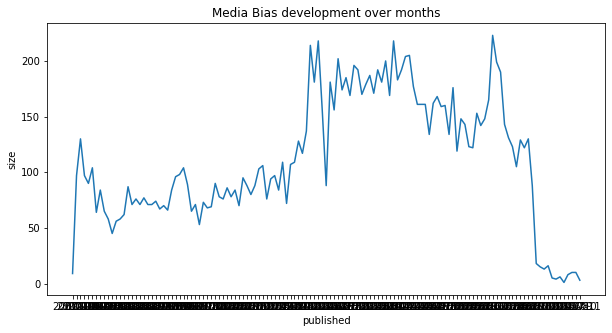

In [168]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='published', y='size', data=sizes_months).set_title('Media Bias development over months')

In [170]:
sizes_months.sort_values(by='size')

,published,size
124,2017-07,1
128,2017-11,3
122,2017-05,4
121,2017-04,5
123,2017-06,6
...,...,...
85,2014-04,205
60,2012-03,214
62,2012-05,218
81,2013-12,218


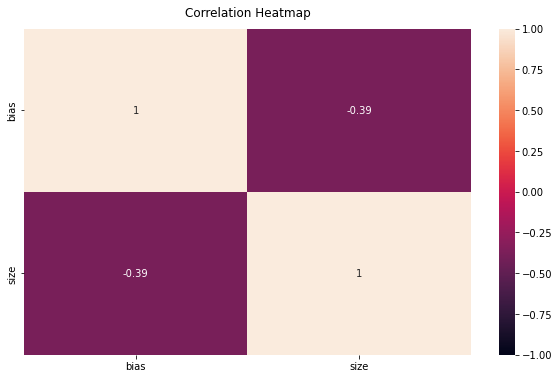

In [167]:
df = new[['bias','size']]
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [172]:
new_years = pd.DataFrame({'bias':df_years['text_bias'],'size':sizes_years['size']})

Text(0.5, 1.0, 'Ammount of articles')

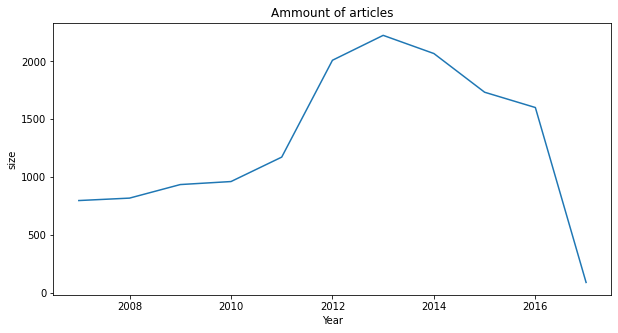

In [177]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='Year', y='size', data=sizes_years).set_title('Ammount of articles')

Text(0.5, 1.0, 'Media Bias development over years')

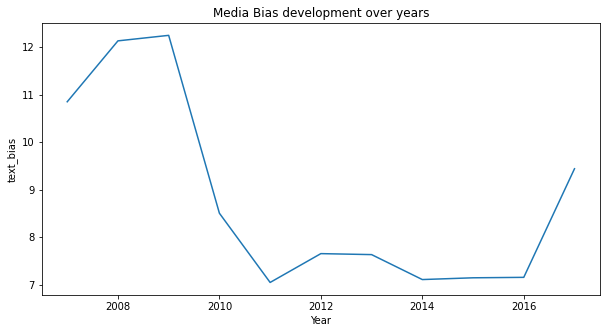

In [178]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='Year', y='text_bias', data=df_years).set_title('Media Bias development over years')

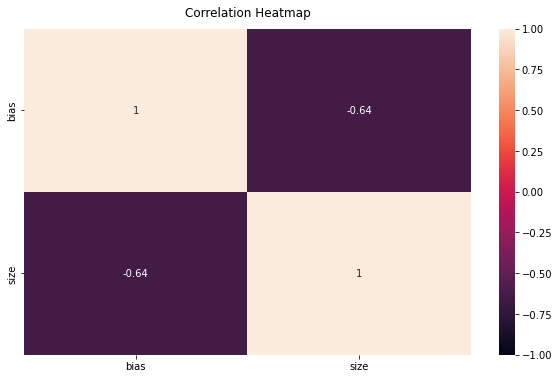

In [175]:
df = new_years[['bias','size']]
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);